In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gabpa510/miniconda3/en

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree
from tensorflow.keras.utils import to_categorical

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.layer.graphsage import AttentionalAggregator
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

In [4]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [5]:
# Auxiliary function to compute d_max
def plotNeighbor(barcodes_df):
    barcodes_df.reset_index(drop=True, inplace=True)
    
    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    d,i = kdT.query(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T,k=2)
    plt.hist(d[:,1],bins=200);
    plt.axvline(x=np.percentile(d[:,1],97),c='r')
    print(np.percentile(d[:,1],97))
    d_th = np.percentile(d[:,1],97)
    return d_th

25.612496949731394


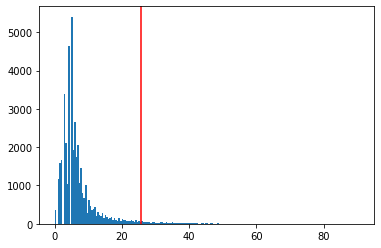

In [6]:
# Load gene panel taglist
tagList_df =pd.DataFrame(['3110035E14Rik','6330403K07Rik','Adgrl2','Aldoc','Arpp21','Atp1b1','Bcl11b','Cadps2','Calb1','Calb2','Calm2','Cck','Cdh13','Chodl','Chrm2','Cnr1','Col25a1','Cort','Cox6a2','Cplx2','Cpne5','Crh','Crhbp','Cryab','Crym','Cux2','Cxcl14','Enc1','Enpp2','Fam19a1','Fos','Fxyd6','Gabrd','Gad1','Gap43','Gda','Grin3a','Hapln1','Htr3a','Id2','Kcnk2','Kctd12','Kit','Lamp5','Lhx6','Ndnf','Neurod6','Nos1','Nov','Npy','Npy2r','Nr4a2','Nrn1','Nrsn1','Ntng1','Pax6','Pcp4','Pde1a','Penk','Plcxd2','Plp1','Pnoc','Prkca','Pthlh','Pvalb','Pvrl3','Qrfpr','Rab3c','Rasgrf2','Rbp4','Reln','Rgs10','Rgs12','Rgs4','Rorb','Rprm','Satb1','Scg2','Sema3c','Serpini1','Slc17a8','Slc24a2','Slc6a1','Snca','Sncg','Sst','Sulf2','Synpr','Tac1','Tac2','Th','Thsd7a','Tmsb10','Trp53i11','Vip','Vsnl1','Wfs1','Yjefn3','Zcchc12'], columns=['Gene'])
# Load spot data for 4_1 right ISS dataset
barcodes_df = pd.read_csv("../data/ISS_Qian_et_al/right-spots.csv", sep = ",", names=['Gene', 'global_Y_pos', 'global_X_pos', 'Q', 'parentCell'],header=0)   
# Compute d_max for generating spatial graph
d_th = plotNeighbor(barcodes_df)

In [8]:
# Auxiliary function to build spatial gene expression graph
def buildGraph(barcodes_df, d_th, tagList_df):
    G = nx.Graph()
    features =[] 
    barcodes_df.reset_index(drop=True, inplace=True)
    
    gene_list = tagList_df.Gene.values
    # Generate node categorical features
    one_hot_encoding = dict(zip(gene_list,to_categorical(np.arange(gene_list.shape[0]),num_classes=gene_list.shape[0]).tolist()))
    barcodes_df["feature"] = barcodes_df['Gene'].map(one_hot_encoding).tolist()
    features.append(np.vstack(barcodes_df.feature.values))

    kdT = KDTree(np.array([barcodes_df.global_X_pos.values,barcodes_df.global_Y_pos.values]).T)
    res = kdT.query_pairs(d_th)
    res = [(x[0],x[1]) for x in list(res)]

    # Add nodes to graph
    G.add_nodes_from((barcodes_df.index.values), test=False, val=False, label=0)
    # Add node features to graph
    nx.set_node_attributes(G,dict(zip((barcodes_df.index.values), barcodes_df.feature)), 'feature')
    # Add edges to graph
    G.add_edges_from(res)

    return G, barcodes_df

In [9]:
# Build spatial gene expression graph
G, barcodes_df = buildGraph(barcodes_df, d_th, tagList_df)

In [14]:
# Remove components with less than N nodes
N=3
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
            G.remove_node(node)

100%|██████████| 2350/2350 [00:00<00:00, 505908.45it/s]


(22403.199688305962, 29020.800311694038, 10445.59968004917, 16922.400319950833)

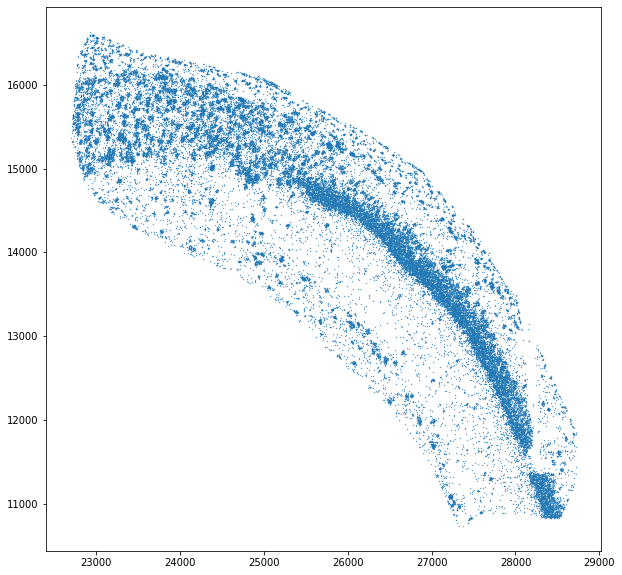

In [11]:
import matplotlib.pyplot as plt

# Remove spots without cell-type label from Qian et al.
barcodes_df = barcodes_df[(barcodes_df.parentCell!=0)]

X = barcodes_df.global_X_pos
Y = barcodes_df.global_Y_pos

plt.figure(figsize=(10,10))
plt.scatter(X,Y,s=0.1)
plt.axis('scaled')

#### 1. Create the Stellargraph with node features.

In [18]:
G = sg.StellarGraph(G, node_features="feature")

In [19]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 40483, Edges: 358145

 Node types:
  0: [40483]
        Attributes: {'val', 'test', 'feature'}
    Edge types: 0-default->0

 Edge types:
    0-default->0: [358145]



#### 2. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [20]:
nodes = list(G.nodes())
number_of_walks = 1
length = 2

#### 3. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [21]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks, seed=42)

#### 4. Create a node pair generator:

In [22]:
batch_size = 50
epochs = 50
num_samples = [20, 10]

In [23]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples, seed=42).flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 3239 batches generated on the fly per epoch.


#### 5. Create neural network model

In [24]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.0, normalize="l2", kernel_regularizer='l1'
)

In [25]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.build()

In [26]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [27]:
import os, datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("pciSeq-%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 99)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 99)      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 20, 99)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200, 99)      0                                            
__________________________________________________________________________________________________
input_1 (I

#### 6. Train neural network model

In [28]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=12,
    shuffle=True,
    callbacks=[tensorboard_callback,earlystop_callback]
)

Epoch 1/50
3239/3239 [==============================] - 65s 20ms/step - loss: 4.3873 - binary_accuracy: 0.7446
Epoch 2/50
3239/3239 [==============================] - 68s 21ms/step - loss: 0.7935 - binary_accuracy: 0.7621
Epoch 3/50
3239/3239 [==============================] - 69s 21ms/step - loss: 0.6026 - binary_accuracy: 0.7649
Epoch 4/50
3239/3239 [==============================] - 64s 20ms/step - loss: 0.5848 - binary_accuracy: 0.7696
Epoch 5/50
3239/3239 [==============================] - 69s 21ms/step - loss: 0.5761 - binary_accuracy: 0.7758
Epoch 6/50
3239/3239 [==============================] - 66s 20ms/step - loss: 0.5708 - binary_accuracy: 0.7782
Epoch 7/50
3239/3239 [==============================] - 69s 21ms/step - loss: 0.5679 - binary_accuracy: 0.7800
Epoch 8/50
3239/3239 [==============================] - 71s 22ms/step - loss: 0.5651 - binary_accuracy: 0.7815
Epoch 9/50
3239/3239 [==============================] - 73s 22ms/step - loss: 0.5643 - binary_accuracy: 0.7809
E

### Extract node embeddings

In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)


In [26]:
# Save the model
embedding_model.save('../models/ISS_Qian_et_al/nn_model.h5')

# Recreate the exact same model purely from the file
embedding_model = keras.models.load_model('../models/ISS_Qian_et_al/nn_model.h5', custom_objects={'AttentionalAggregator':AttentionalAggregator})

In [27]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 99)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 99)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1, 99)        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 20, 99)    0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [28]:
embedding_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

In [30]:
nodes = list(G.nodes())
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=42).flow(nodes)

In [31]:
node_embeddings = embedding_model.predict_generator(node_gen, workers=12, verbose=1)

810/810 [==============================] - 31s 39ms/step


In [32]:
np.save('../results/ISS_Qian_et_al/embedding_ISS_right.npy',node_embeddings)

In [33]:
# quit()

# Predict node embeeding for 4-1 left data

26.0


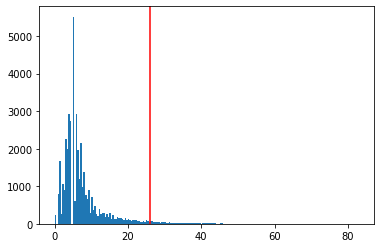

In [39]:
# Load spot data for 4_1 left from Qian et al.
barcodes_df = pd.read_csv("../data/ISS_Qian_et_al/left-spots.csv", sep = ",", names=['Gene', 'global_Y_pos', 'global_X_pos', 'Q', 'parentCell'],header=0)   
# Compute d_max threshold
d_th = plotNeighbor(barcodes_df)

In [41]:
# Build spatial gene expression graph
G, barcodes_df = buildGraph(barcodes_df, d_th, tagList_df)
barcodes_df.shape

(42432, 6)

In [43]:
# Remove components with less than N nodes
N=3
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
            G.remove_node(node)

100%|██████████| 2514/2514 [00:00<00:00, 424018.03it/s]


(4503.749688305966, 11351.250311694035, 11570.04968004917, 17530.950319950833)

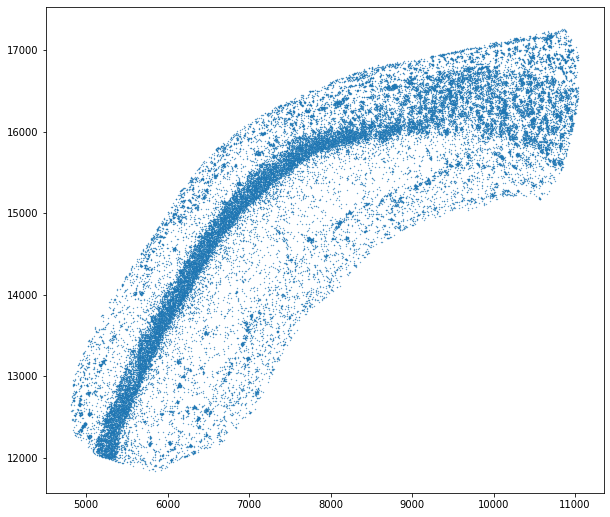

In [42]:
import matplotlib.pyplot as plt

# Remove spots without cell-type label from Qian et al.
barcodes_df = barcodes_df[(barcodes_df.parentCell!=0)]

X = barcodes_df.global_X_pos
Y = barcodes_df.global_Y_pos

plt.figure(figsize=(10,10))
plt.scatter(X,Y,s=0.1)
plt.axis('scaled')

In [45]:
# Build Stellargraph instance
G = sg.StellarGraph(G, node_features="feature")
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 40320, Edges: 355023

 Node types:
  0: [40320]
        Attributes: {'val', 'test', 'feature'}
    Edge types: 0-default->0

 Edge types:
    0-default->0: [355023]



In [46]:
# Load neural network model
embedding_model = keras.models.load_model('../models/ISS_Qian_et_al/nn_model.h5', custom_objects={'AttentionalAggregator':AttentionalAggregator})

In [47]:
# Compile neural networkmodel
embedding_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

# Predict node embedding
batch_size = 50
num_samples = [20, 10]

nodes = list(G.nodes())
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=42).flow(nodes)

node_embeddings = embedding_model.predict_generator(node_gen, workers=12, verbose=1)

807/807 [==============================] - 25s 31ms/step


In [48]:
np.save('../results/ISS_Qian_et_al/embedding_ISS_left.npy',node_embeddings)

In [49]:
quit()